## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#==========================================================
#
#  This prepare the hdf5 datasets of the DRIVE database
#
#============================================================

In [ ]:
#!pip install h5py

In [ ]:
import h5py

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

from keras.applications.vgg16 import VGG16

In [ ]:
def write_hdf5(arr,outfile):
  with h5py.File(outfile,"w") as f:
    f.create_dataset("image", data=arr, dtype=arr.dtype)
    
def load_hdf5(infile):
  with h5py.File(infile,"r") as f:  #"with" close the file after its nested commands
    return f["image"][()]

## Load the dataset

In [ ]:
#------------Path of the images --------------------------------------------------------------
#train
original_imgs_train = "gdrive/My Drive/PLOS/Total_FCN_train_200_SY/images/"
groundTruth_imgs_train = "gdrive/My Drive/PLOS/Total_FCN_train_SY_real/1st_manual/"
#---------------------------------------------------------------------------------------------

In [ ]:
#------------Path of the images --------------------------------------------------------------
#test
original_imgs_test = "/content/gdrive/My Drive/PLOS/Experimental_method/05_test/test/"
#---------------------------------------------------------------------------------------------

In [ ]:
Nimgs = 200
Ntest = 80
channels = 3
height = 480
width = 640
dataset_path = "gdrive/My Drive/PLOS/DRIVE_datasets_training_testing1/"

In [ ]:
def get_datasets(imgs_dir,groundTruth_dir):
    imgs = np.empty((Nimgs,height,width,channels))
    groundTruth = np.empty((Nimgs,height,width,2)) # depend on object#3
    for path, subdirs, files in os.walk(imgs_dir): #list all files, directories in the path
        for i in range(len(files)):
            #original
            print ("original image: " +files[i])
            img = Image.open(imgs_dir+files[i])
            img = img.resize((width,height), Image.ANTIALIAS)
            temp = np.asarray(img)/255
            #temp = np.append(temp, np.zeros((584,11,3)), axis = 1)
            #temp = temp[:height, :width, :]
            imgs[i] = temp
            #corresponding ground truth
            groundTruth_name = files[i][0:4] + ".gif"
            print ("ground truth name: " + groundTruth_name)
            g_truth = Image.open(groundTruth_dir + groundTruth_name)
            g_truth = g_truth.resize((width,height), Image.ANTIALIAS)
            temp = np.asarray(g_truth)/255
            a = (np.max(temp)+np.min(temp))/2.0
            temp = (temp>a) * 1.0
            #temp = np.append(temp, np.zeros((584,11)), axis = 1)
            #temp = temp[:height, :width]
            
            if files[i][1] == '0' or files[i][1] == '1' : # depend on object
                groundTruth[i,:,:,0] = temp
                
#            elif files[i][0] == '1':
#                groundTruth[i,:,:,1] = temp
#                
#            elif files[i][0] == '2':
#                groundTruth[i,:,:,2] = temp
#                
#            elif files[i][0] == '3':
#                groundTruth[i,:,:,3] = temp
            
            groundTruth[i,:,:,1] = 1 - temp
            
    print ("imgs max: " +str(np.max(imgs)))
    print ("imgs min: " +str(np.min(imgs)))
    print ("ground truth are correctly withih pixel value range 0-255 (black-white)")
    return imgs, groundTruth

In [ ]:
def get_datasets2(test_dir):
    test = np.empty((Ntest,height,width,channels))
    
    for path, subdirs, files in os.walk(test_dir): #list all files, directories in the path
        #for j in range(len(files)):
          for i in range(len(files)):
            #if files[i][0:3] == '%03d' %j :
              #test
              print ("test image: " +files[i] + str(i))
              img = Image.open(test_dir+files[i])
              img = img.resize((width,height), Image.ANTIALIAS)
              temp = np.asarray(img)/255
              #temp = np.append(temp, np.zeros((584,11,3)), axis = 1)
              #temp = temp[:height, :width, :]
              test[i] = temp
              
            
    print ("test max: " +str(np.max(test)))
    print ("test min: " +str(np.min(test)))
    return test

In [ ]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

imgs_train, groundTruth_train = get_datasets(original_imgs_train,groundTruth_imgs_train)
imgs_test = get_datasets2(original_imgs_test)
print ("saving test datasets")
write_hdf5(imgs_train,dataset_path + "DRIVE_dataset_imgs_train.hdf5")
write_hdf5(imgs_test,dataset_path + "DRIVE_dataset_imgs_test.hdf5")
write_hdf5(groundTruth_train, dataset_path + "DRIVE_dataset_groundTruth_train.hdf5")

In [ ]:
DRIVE_train_imgs_original = dataset_path + "DRIVE_dataset_imgs_train.hdf5"
DRIVE_test_imgs_original = dataset_path + "DRIVE_dataset_imgs_test.hdf5"
DRIVE_train_groudTruth = dataset_path + "DRIVE_dataset_groundTruth_train.hdf5"  #masks

In [ ]:
train_imgs = load_hdf5(DRIVE_train_imgs_original)
test_imgs = load_hdf5(DRIVE_test_imgs_original)
train_seg = load_hdf5(DRIVE_train_groudTruth)

In [ ]:
#train_imgs = np.delete(train_imgs, 0, 2)
#train_imgs = np.append(train_imgs, np.zeros(1,height,), axis = 2)
test_imgs.shape

(80, 480, 640, 3)

In [ ]:
#train_seg = np.delete(train_seg, 0, 2)
train_seg.shape

(200, 480, 640, 2)

In [ ]:
np.max(train_imgs[0])

In [ ]:
np.max(train_seg[90, :, :, 1])

In [ ]:
np.min(train_seg[0, :, :, 1])

In [ ]:
np.min(train_seg[0, :, :, 1] > 0.994)

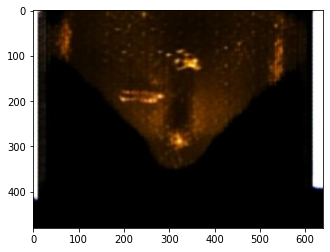

In [ ]:
plt.imshow(test_imgs[51])

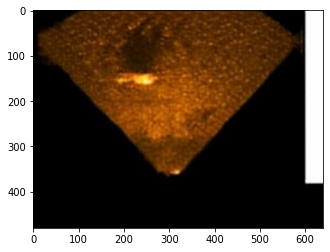

In [ ]:
idx = np.random.randint(Nimgs)
plt.imshow(train_imgs[idx])

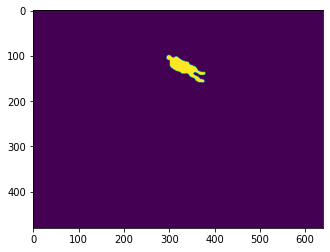

In [ ]:
plt.imshow(train_seg[idx][:,:,0])

In [ ]:
plt.imshow(train_seg[idx][:,:,1])

In [ ]:
plt.imshow(train_seg[idx][:,:,2])

In [ ]:
plt.imshow(train_seg[idx][:,:,3])

In [ ]:
plt.imshow(train_seg[idx][:,:,4])

## Training

In [ ]:
model = VGG16(weights = 'imagenet')

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
vgg16_weights = model.get_weights()

weights = {
    'conv1_1' : tf.constant(vgg16_weights[0]),
    'conv1_2' : tf.constant(vgg16_weights[2]),
    
    'conv2_1' : tf.constant(vgg16_weights[4]),
    'conv2_2' : tf.constant(vgg16_weights[6]),
    
    'conv3_1' : tf.constant(vgg16_weights[8]),
    'conv3_2' : tf.constant(vgg16_weights[10]),
    'conv3_3' : tf.constant(vgg16_weights[12]),
    
    'conv4_1' : tf.constant(vgg16_weights[14]),
    'conv4_2' : tf.constant(vgg16_weights[16]),
    'conv4_3' : tf.constant(vgg16_weights[18]),
    
    'conv5_1' : tf.constant(vgg16_weights[20]),
    'conv5_2' : tf.constant(vgg16_weights[22]),
    'conv5_3' : tf.constant(vgg16_weights[24]),
}

biases = {
    'conv1_1' : tf.constant(vgg16_weights[1]),
    'conv1_2' : tf.constant(vgg16_weights[3]),
    
    'conv2_1' : tf.constant(vgg16_weights[5]),
    'conv2_2' : tf.constant(vgg16_weights[7]),
    
    'conv3_1' : tf.constant(vgg16_weights[9]),
    'conv3_2' : tf.constant(vgg16_weights[11]),
    'conv3_3' : tf.constant(vgg16_weights[13]),
    
    'conv4_1' : tf.constant(vgg16_weights[15]),
    'conv4_2' : tf.constant(vgg16_weights[17]),
    'conv4_3' : tf.constant(vgg16_weights[19]),
    
    'conv5_1' : tf.constant(vgg16_weights[21]),
    'conv5_2' : tf.constant(vgg16_weights[23]),
    'conv5_3' : tf.constant(vgg16_weights[25]),
}

# input layer and output layer
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, 2])

In [ ]:
def fcn(x, weights, biases):
    # First convolution layers
    conv1_1 = tf.nn.conv2d(x, 
                         weights['conv1_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1_1 = tf.nn.relu(tf.add(conv1_1, biases['conv1_1']))
    conv1_2 = tf.nn.conv2d(conv1_1, 
                         weights['conv1_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv1_2 = tf.nn.relu(tf.add(conv1_2, biases['conv1_2']))
    maxp1 = tf.nn.max_pool(conv1_2, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # Second convolution layers
    conv2_1 = tf.nn.conv2d(maxp1, 
                         weights['conv2_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2_1 = tf.nn.relu(tf.add(conv2_1, biases['conv2_1']))
    conv2_2 = tf.nn.conv2d(conv2_1, 
                         weights['conv2_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv2_2= tf.nn.relu(tf.add(conv2_2, biases['conv2_2']))
    maxp2 = tf.nn.max_pool(conv2_2, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # third convolution layers
    conv3_1 = tf.nn.conv2d(maxp2, 
                         weights['conv3_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv3_1 = tf.nn.relu(tf.add(conv3_1, biases['conv3_1']))
    conv3_2 = tf.nn.conv2d(conv3_1, 
                         weights['conv3_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv3_2= tf.nn.relu(tf.add(conv3_2, biases['conv3_2']))
    conv3_3 = tf.nn.conv2d(conv3_2, 
                         weights['conv3_3'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv3_3= tf.nn.relu(tf.add(conv3_3, biases['conv3_3']))
    maxp3 = tf.nn.max_pool(conv3_3, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # fourth convolution layers
    conv4_1 = tf.nn.conv2d(maxp3, 
                         weights['conv4_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv4_1 = tf.nn.relu(tf.add(conv4_1, biases['conv4_1']))
    conv4_2 = tf.nn.conv2d(conv4_1, 
                         weights['conv4_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv4_2= tf.nn.relu(tf.add(conv4_2, biases['conv4_2']))
    conv4_3 = tf.nn.conv2d(conv4_2, 
                         weights['conv4_3'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv4_3= tf.nn.relu(tf.add(conv4_3, biases['conv4_3']))
    maxp4 = tf.nn.max_pool(conv4_3, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')

    # fifth convolution layers
    conv5_1 = tf.nn.conv2d(maxp4, 
                         weights['conv5_1'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv5_1 = tf.nn.relu(tf.add(conv5_1, biases['conv5_1']))
    conv5_2 = tf.nn.conv2d(conv5_1, 
                         weights['conv5_2'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv5_2= tf.nn.relu(tf.add(conv5_2, biases['conv5_2']))
    conv5_3 = tf.nn.conv2d(conv5_2, 
                         weights['conv5_3'], 
                         strides = [1, 1, 1, 1], 
                         padding = 'SAME')
    conv5_3= tf.nn.relu(tf.add(conv5_3, biases['conv5_3']))
    maxp5 = tf.nn.max_pool(conv5_3, 
                           ksize = [1, 2, 2, 1], 
                           strides = [1, 2, 2, 1], 
                           padding = 'VALID')
    
    # sixth convolution layer
    conv6 = tf.layers.conv2d(maxp5,
                            filters = 4096,
                            kernel_size = 7,
                            padding = 'SAME',
                            activation = tf.nn.relu)
    
    # 1x1 convolution layers
    fcn4 = tf.layers.conv2d(conv6,
                            filters = 4096,
                            kernel_size = 1,
                            padding = 'SAME',
                            activation = tf.nn.relu)
    fcn3 = tf.layers.conv2d(fcn4,
                            filters = 3, #2,
                            kernel_size = 1,
                            padding = 'SAME')

    # Upsampling layers
    fcn2 = tf.layers.conv2d_transpose(fcn3,
                                      filters = 512,
                                      kernel_size = 4,
                                      strides = (2, 2),
                                      padding = 'SAME')
    
    fcn1 = tf.layers.conv2d_transpose(fcn2 + maxp4,
                                      filters = 256,
                                      kernel_size = 4,
                                      strides = (2, 2),
                                      padding = 'SAME')
    
    output = tf.layers.conv2d_transpose(fcn1 + maxp3, 
                                     filters = 2, # depend on object #2,
                                     kernel_size = 16,
                                     strides = (8, 8),
                                     padding = 'SAME')

    return output

In [ ]:
LR  = 0.001 # we can try to change option

pred = fcn(x, weights, biases)
logits = tf.reshape(pred, (-1, 2))
labels = tf.reshape(y, (-1, 2))

loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = labels)
loss = tf.reduce_mean(loss)

optm  = tf.train.AdamOptimizer(LR).minimize(loss)

In [ ]:
def train_batch_maker(batch_size):
    random_idx = np.random.randint(Nimgs, size = batch_size)
    #print ("Epoch : {}".format(random_idx))
    return train_imgs[random_idx], train_seg[random_idx]

In [ ]:
n_batch = 5 # we can try to change option
n_epoch = 200 # we can try to change option
n_prt = 10     # depend on object

sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss_record_train = []

In [ ]:
for epoch in range(n_epoch):
    train_x, train_y = train_batch_maker(n_batch)
    sess.run(optm, feed_dict = {x: train_x, y: train_y})

    if epoch % n_prt == 0:        
        c = sess.run(loss, feed_dict = {x: train_x, y: train_y})
        loss_record_train.append(c)
        print ("Epoch : {}".format(epoch))
        print ("Cost : {}".format(c))
        


Epoch : 0
Cost : 0.0859537348151207
Epoch : 10
Cost : 0.05546261742711067
Epoch : 20
Cost : 0.02024809457361698
Epoch : 30
Cost : 0.02866581454873085
Epoch : 40
Cost : 0.011036795563995838
Epoch : 50
Cost : 0.00913210492581129
Epoch : 60
Cost : 0.0070901247672736645
Epoch : 70
Cost : 0.005691873375326395
Epoch : 80
Cost : 0.0063706799410283566
Epoch : 90
Cost : 0.0054031237959861755
Epoch : 100
Cost : 0.0040895454585552216
Epoch : 110
Cost : 0.0051912968046963215
Epoch : 120
Cost : 0.004491347819566727
Epoch : 130
Cost : 0.005337880924344063
Epoch : 140
Cost : 0.004135415889322758
Epoch : 150
Cost : 0.003351920982822776
Epoch : 160
Cost : 0.003524922067299485
Epoch : 170
Cost : 0.0033523524180054665
Epoch : 180
Cost : 0.004940088372677565
Epoch : 190
Cost : 0.004613571334630251


In [ ]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, label = 'training')
plt.xlabel('epoch', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

## Generate using test dataset & Saving Data

In [ ]:
def test_batch_maker(batch_size):
    data1 = [batch_size]
    random_idx = np.array(data1)
#    for path, subdirs, files in os.walk(original_imgs_test): #list all files, directories in the path
#      for i in range(len(files)):
#          if files[i][0:3] == '%03d' %random_idx:
    print ("test image: " + str(random_idx)) 
#              data2=[i]
#              random_idx=np.array(data2)
            
    return test_imgs[random_idx]

In [ ]:
#plt.figure(figsize = (16,16))
i = 0
while i <= 79:
#for path, subdirs, files in os.walk(original_imgs_test): #list all files, directories in the path
#  for i in range(len(files)):
  test_x = test_batch_maker(i)
  #plt.subplot(10,10,i)
  test_img = sess.run(tf.nn.softmax(logits), feed_dict = {x: test_x})
  test_img = test_img[:, 0].reshape(height, width)
  segmentation = (test_img > 0.5).reshape(height, width, 1)
  #segmentation1 = (test_img > 0.5).reshape(height, width)

  mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
  mask = Image.fromarray((mask).astype('uint8'), mode = "RGBA")
  street_im = Image.fromarray((test_x[0] * 255).astype('uint8'))
  street_im.paste(mask, box = None, mask = mask)


  dir_street_im = '/content/gdrive/My Drive/PLOS/Total_FCN_Result_200_SY/images/%04d.jpg' %i
  dir_mask = '/content/gdrive/My Drive/PLOS/Total_FCN_Result_200_SY/mask/%04d_mask.gif' %i

  street_im.save(dir_street_im)
  mask.save(dir_mask)

  i += 1
    
